# NCAA Basketball March Madness Outcome Prediction

----------------------------------------------
----------------------------------------------
# 1 ) Data Visualization

The most challenging aspect of this project is choosing which data to use and in which format. Sports-reference.com has tracked NCAA bracket data dating back to 1939, however, there are two problems with using data from 1939:
- there are 8 teams total in the whole tournament (compared to 64 in modern times)
- the game of basketball has changed a ton since that (so is it even worth it?)
Thus, data should be used for more recent years. Another big problem is the lack of available, large, good datasets which track the (what I believe to be) relevant stats which go into a basketball matchup. NCAA matchups are different than typical games in that you have additional information of team seeding, SOS, etc.

So far, I have done some manual work to reconstruct matchup data for the past few years. Going forward, the two main adjustments to be made insofar as data are:
- Web scraping to automate data acquisition
- transfer learning from NCAA regular season/NBA games to increase the size of the training set

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotting_tools as ptool
from sklearn import metrics
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ncaa_df = pd.read_csv(r"C:\Users\Mattz\OneDrive\Studies\Data Projects\March_Madness\Fall2020\ncaa.csv")

A fundamental part of my classification method is as follows: for a given basketball matchup, instead of looking at the raw stats for both teams, look at the difference between their head-to-head statistics, e.g.:
- difference in seed ranking
- difference in points per game
- difference in strength of schedule
etc...

This is done to help the model learn faster and more efficiently given the smallness of the training set

In [4]:
# view a few examples
ncaa_df.head()

,Team0,Team1,Seed0,Seed1,SeedDif,WP0,WP1,WPDiff,SOS0,SOS1,...,Ast0,Ast1,AstDiff,Winner,Year,Region,Round,Point0,Point1,PointDiff
0,Duke,ND State,1.0,16.0,15.0,0.842105,0.542857,0.299248,11.97,-2.07,...,15.9,11.5,4.4,0.0,2019,East,1.0,85.0,62.0,23
1,VCU,UCF,8.0,9.0,1.0,0.757576,0.727273,0.030303,11.96,5.58,...,13.6,13.3,0.3,1.0,2019,East,1.0,58.0,73.0,-15
2,Miss St,Liberty,5.0,12.0,7.0,0.676471,0.805556,-0.129085,9.07,-3.88,...,14.1,14.8,-0.7,1.0,2019,East,1.0,76.0,80.0,-4
3,Virginia Tech,St Louis,4.0,13.0,9.0,0.742857,0.638889,0.103968,7.79,2.23,...,15.2,12.8,2.4,0.0,2019,East,1.0,66.0,52.0,14
4,Maryland,Belmont,6.0,11.0,5.0,0.676471,0.818182,-0.141711,10.09,-2.60,...,13.1,19.5,-6.4,0.0,2019,East,1.0,79.0,77.0,2


In any given matchup, the first team listed is 'Team0', and the second team listed is 'Team1'. 

Our goal is for the algorithm to predict if Team0 will win (0 -> yes, 1 -> no, classification) or what difference the final score will be between the teams (regression)

In [5]:
# get the dtypes of our variables
ncaa_df.dtypes.head()

Team0       object
Team1       object
Seed0      float64
Seed1      float64
SeedDif    float64
dtype: object

__visualize the numeric variables__

In [6]:
num_cols = ['WP0', 'WP1', 'WPDiff', 'SOS0', 'SOS1', 'SOSDiff', 'ORtg0', 'ORtg1', 'ORtgDiff', 'DRtg0',
        'DRtg1', 'DRtgDiff', 'FG0', 'FG1', 'FGDiff', '3P0', '3P1', '3PDiff', 'TRb0', 'TRb1', 'TRbDiff', 'Ast0', 'Ast1', 'AstDiff']

print(len(num_cols))

24


Note that Team0 will generally be the higher seed (if not, it will be an upset in a later round).

From the plot below, we can see that the first team tends to have stronger statistics across the board (winning percentage, strength of schedule, offensive/defensive rating, shooting, rebounding, etc.

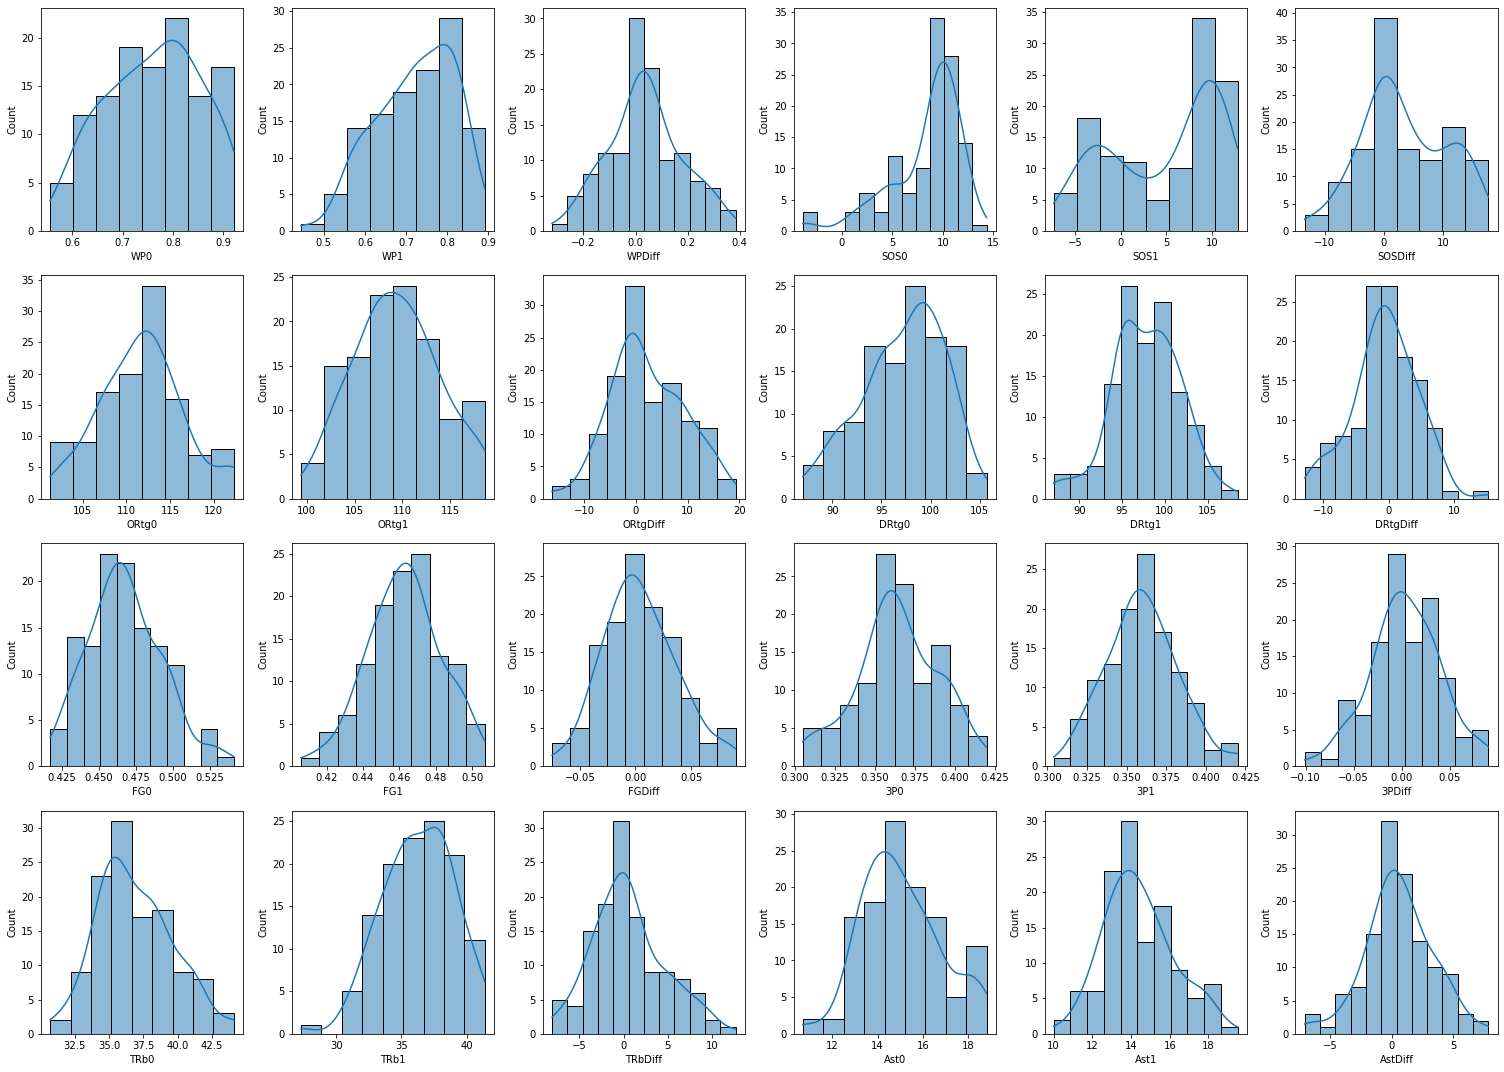

In [7]:
fig = plt.figure(figsize=(21, 15))
fig.subplots_adjust(hspace=0.2)

for i, j in enumerate(num_cols):
    plt.subplot(4, 6, i+1)
    sns.histplot(data=ncaa_df, x=ncaa_df[j], kde=True)
    
fig.tight_layout()

In [8]:
dif_cols = ['WPDiff', 'SOSDiff', 'ORtgDiff', 'DRtgDiff', 'FGDiff', '3PDiff', 'TRbDiff']

we can look at the summary statistics that describe the difference in numeric variables between the two teams

In [9]:
for x in dif_cols:
    print("stat: {}, summary: {}".format(x, stats.describe(ncaa_df[x])))

stat: WPDiff, summary: DescribeResult(nobs=126, minmax=(-0.32046332, 0.384126984), mean=0.036931141619047626, variance=0.02020984876077426, skewness=0.10999858572085575, kurtosis=-0.25293488889607696)
stat: SOSDiff, summary: DescribeResult(nobs=126, minmax=(-13.37, 17.63), mean=3.461587301587302, variance=51.308463060317465, skewness=0.07874487209868244, kurtosis=-0.7243871939892972)
stat: ORtgDiff, summary: DescribeResult(nobs=126, minmax=(-16.2, 19.3), mean=2.3246031746031743, variance=50.39994984126982, skewness=0.1548638800751055, kurtosis=-0.35242427090046213)
stat: DRtgDiff, summary: DescribeResult(nobs=126, minmax=(-12.8, 15.2), mean=-0.6023809523809525, variance=24.64855428571428, skewness=-0.12041483495101887, kurtosis=0.2423947309313692)
stat: FGDiff, summary: DescribeResult(nobs=126, minmax=(-0.075, 0.09), mean=0.004388888888888889, variance=0.0010737595555555552, skewness=0.3293341920992273, kurtosis=-0.03157070911179227)
stat: 3PDiff, summary: DescribeResult(nobs=126, minm

- Strength of schedule (SOSDiff) is generally higher for team0 although there is variance. 
- Offensive rating (ORtgDiff) is generally higher as well for Team 0 but this effect is less pronounced for defensive rating (DRtgDiff). This could be because at weaker levels of competition, opponent offences tend to be less effective in general, and thus the defensive rating is higher for a weaker team than if they were to play in a stronger pool of competition
- field goal and shooting statistics are pretty even, while rebounding tends to be higher for the first team (usually higher seed)

__look for any outliers, view distributions in boxplots__

boxplots to help visualize the distributions further, show the means, IQRs, and help identify any outliers in the data

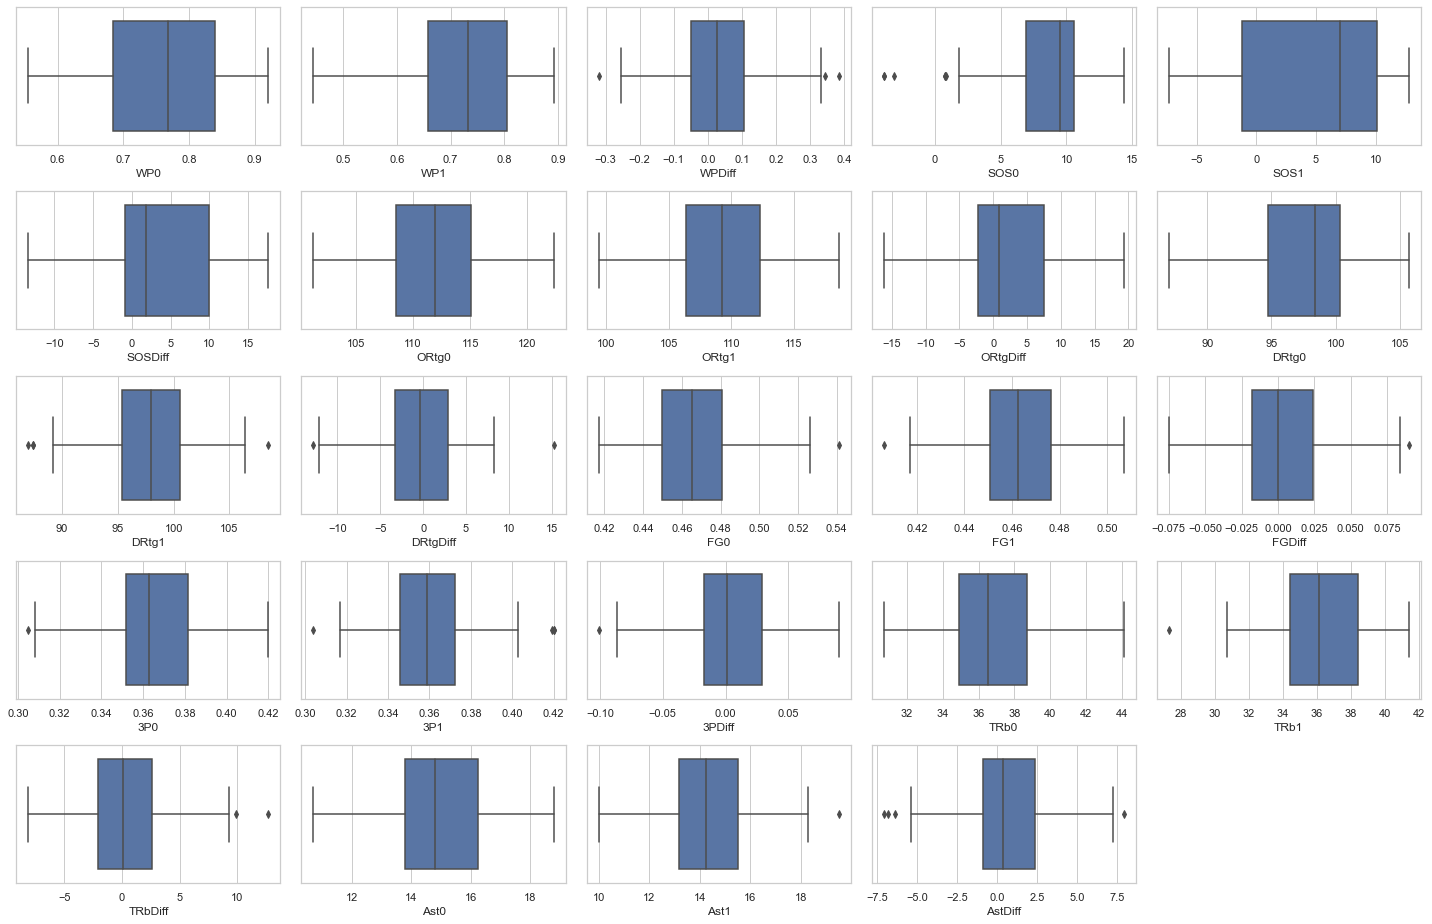

In [10]:
fig = plt.figure(figsize=(20, 13))
fig.subplots_adjust(hspace=0.9)
sns.set_theme(style='whitegrid')

for i, j in enumerate(num_cols):
    plt.subplot(5, 5, i+1)
    ax = sns.boxplot(x=ncaa_df[j])

fig.tight_layout()

__variable correlations__
let's view the relationships between the variables

In [11]:
numeric_ncaa_df = pd.read_csv(r"C:\Users\Mattz\OneDrive\Studies\Data Projects\March_Madness\Fall2020\ncaa.csv")

In [12]:
numeric_ncaa_df = numeric_ncaa_df.drop(columns=['Team0', 'Team1', 'Round', 'Year', 'Region', 'SeedDif', 'WPDiff', 'SOSDiff', 'ORtgDiff', 'DRtgDiff',
                                               'FGDiff', '3PDiff', 'TRbDiff', 'AstDiff'])

In [13]:
print(numeric_ncaa_df.columns)

Index(['Seed0', 'Seed1', 'WP0', 'WP1', 'SOS0', 'SOS1', 'ORtg0', 'ORtg1',
       'DRtg0', 'DRtg1', 'FG0', 'FG1', '3P0', '3P1', 'TRb0', 'TRb1', 'Ast0',
       'Ast1', 'Winner', 'Point0', 'Point1', 'PointDiff'],
      dtype='object')


there are some interesting relationships below, but let's simplify to a smaller dimension

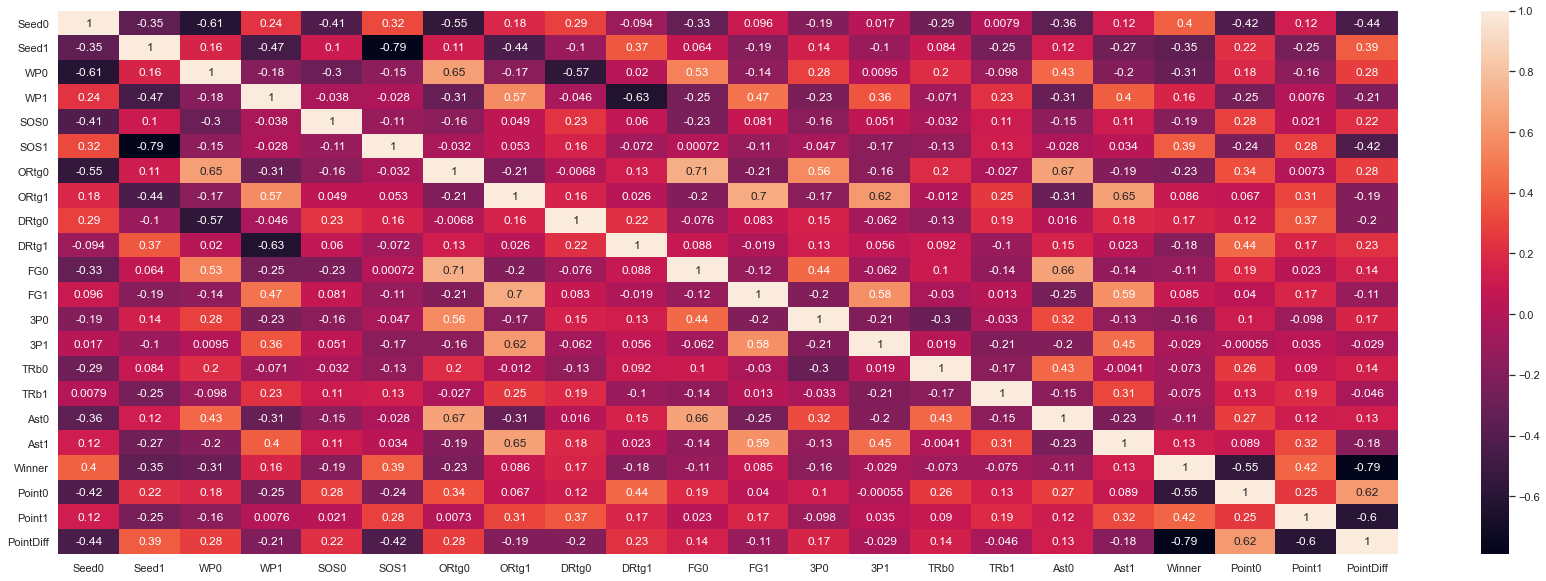

<Figure size 432x288 with 0 Axes>

In [14]:
corr_matrix = numeric_ncaa_df.corr()
fig = plt.figure(figsize=(30,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()
plt.savefig('corr_matrix.png', bbox_inches='tight')

In [15]:
ncaa_matchup_df = pd.read_csv(r"C:\Users\Mattz\OneDrive\Studies\Data Projects\March_Madness\Fall2020\ncaa.csv")

In [16]:
ncaa_matchup_df.columns

Index(['Team0', 'Team1', 'Seed0', 'Seed1', 'SeedDif', 'WP0', 'WP1', 'WPDiff',
       'SOS0', 'SOS1', 'SOSDiff', 'ORtg0', 'ORtg1', 'ORtgDiff', 'DRtg0',
       'DRtg1', 'DRtgDiff', 'FG0', 'FG1', 'FGDiff', '3P0', '3P1', '3PDiff',
       'TRb0', 'TRb1', 'TRbDiff', 'Ast0', 'Ast1', 'AstDiff', 'Winner', 'Year',
       'Region', 'Round', 'Point0', 'Point1', 'PointDiff'],
      dtype='object')

drop the absolute number variables and string variables

In [17]:
ncaa_matchup_df = ncaa_matchup_df.drop(columns=['Team0', 'Team1', 'Round', 'Year', 'Region', 'Seed0', 'Seed1', 'WP0', 'WP1', 'SOS0', 'SOS1', 'ORtg0', 'ORtg1',
                                                'DRtg0', 'DRtg1', 'FG0', 'FG1', '3P0', '3P1', 'TRb0', 'TRb1', 'Point0', 'Point1', 'Ast0', 'Ast1'])

In [18]:
ncaa_matchup_df.columns

Index(['SeedDif', 'WPDiff', 'SOSDiff', 'ORtgDiff', 'DRtgDiff', 'FGDiff',
       '3PDiff', 'TRbDiff', 'AstDiff', 'Winner', 'PointDiff'],
      dtype='object')

from the correlation matrix below we can look at various correlations, especially the relationships to winning (note that negative number correlations to the winning variable are because winning is 0 and losing is 1). We find strong correlations:
- between winning percentage and defensive rating (defense wins championships!)
- between the winner and seed difference
- between 3 point shooting/field goal shooting and offensive rating

etc...

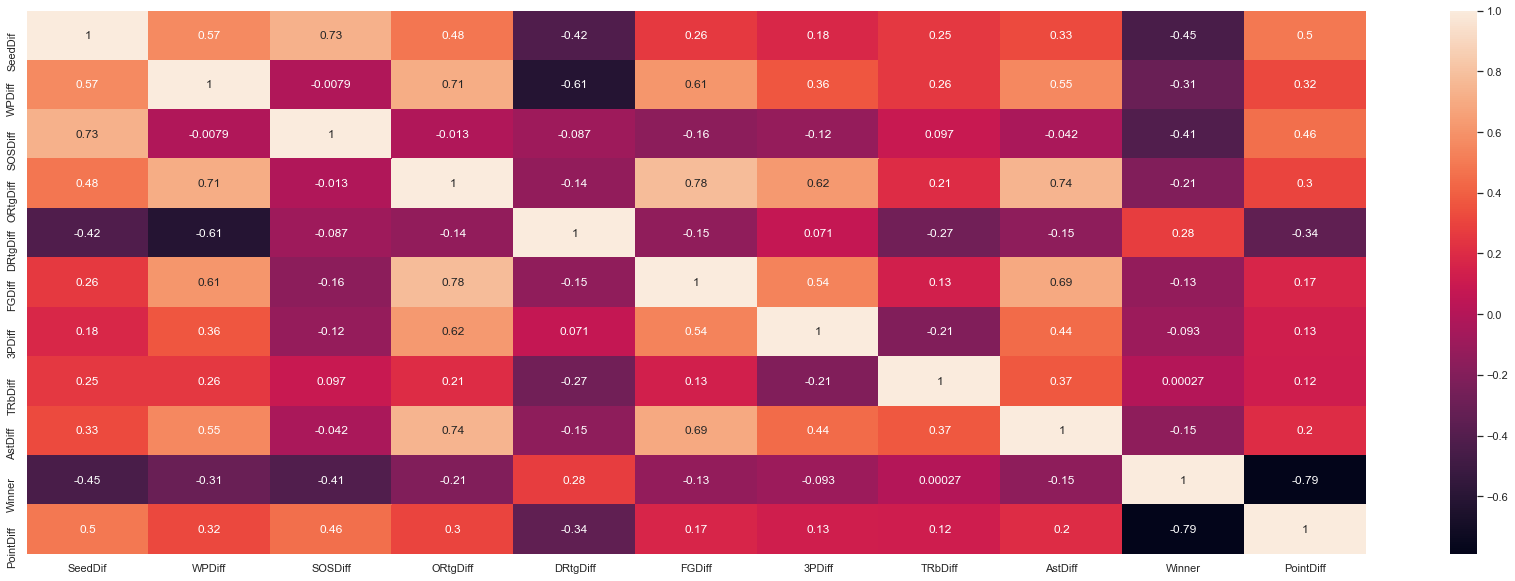

<Figure size 432x288 with 0 Axes>

In [19]:
corr_matrix = ncaa_matchup_df.corr()
fig = plt.figure(figsize=(30,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()
plt.savefig('corr_matrix.png', bbox_inches='tight')

__scatterplots__

In viewing the relationship of the various numeric variables to the matchup point difference (linear regression), we can see:
- general increase of point difference for team0 for higher seeds (given some outliers)
- a small sloping increase in point differential based on winning percentage
- similar pattern for strength of schedule as for seed difference
- a small positive slope for field goal and offensive rating differential vs point differential
- interestingly, a negative slope for defensive rating difference to point differential! This could be due to the aforementioned overbias of defensive rating for teams in poor conferences

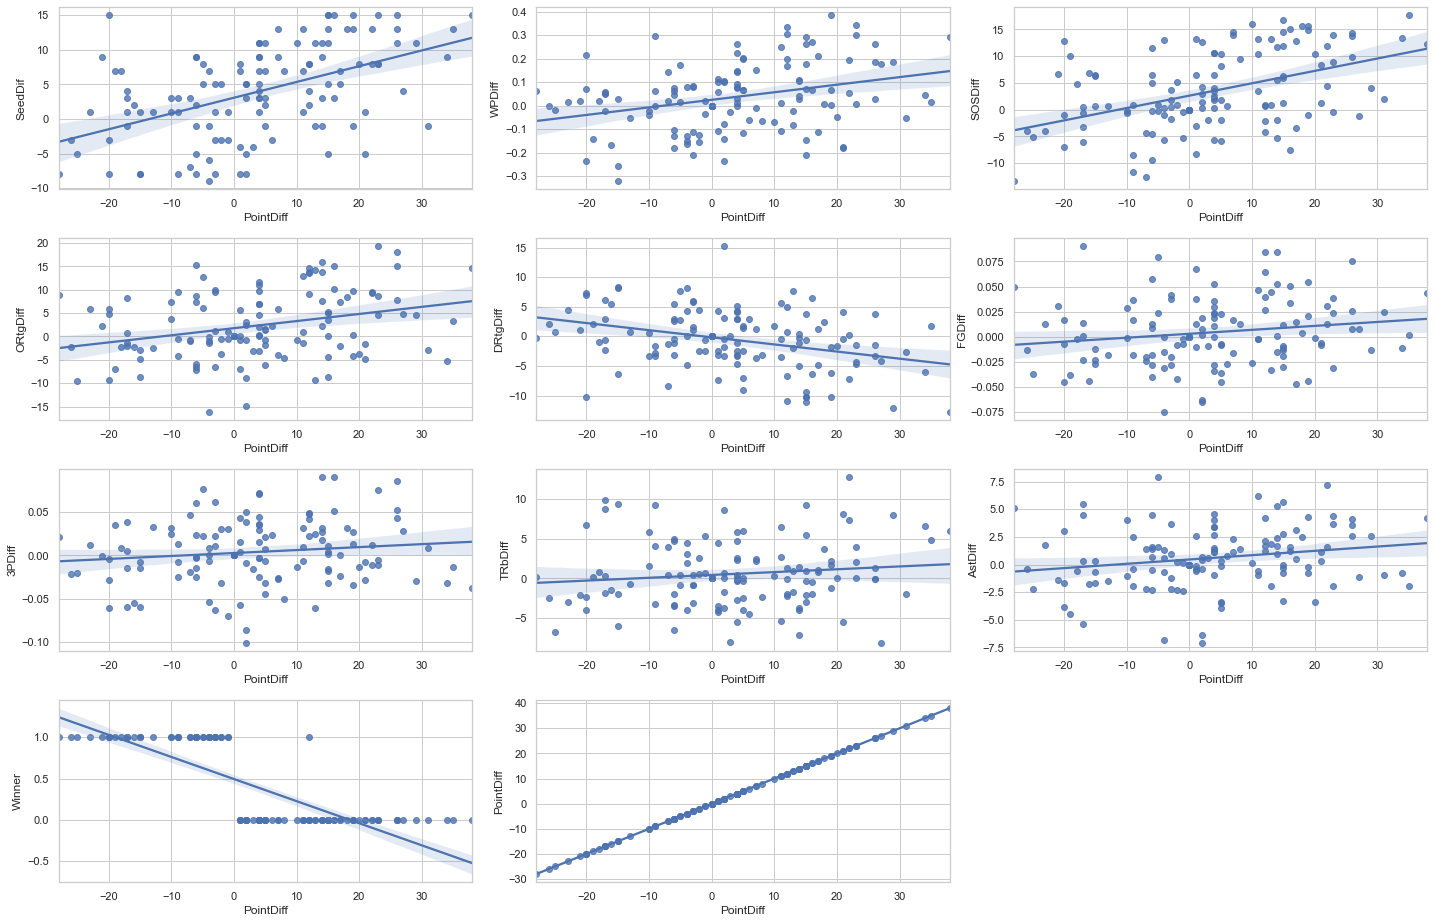

In [20]:
fig = plt.figure(figsize=(20, 13))
fig.subplots_adjust(hspace=0.9)

for i, j in enumerate(ncaa_matchup_df.columns):
    plt.subplot(4, 3, i+1)
    ax = sns.regplot(x=ncaa_matchup_df["PointDiff"], y=ncaa_matchup_df[j], data=ncaa_matchup_df)

fig.tight_layout()

# 2) linear regression

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model

import matplotlib.pyplot as plt
import math
import sklearn.metrics as skm
from scipy.stats import zscore
import pandas as pd
import numpy as np

In [25]:
train_cols = ['SeedDif', 'WPDiff', 'SOSDiff', 'ORtgDiff', 'DRtgDiff', 'FGDiff', '3PDiff', 'TRbDiff', 'AstDiff']

In [26]:
ncaa_matchup_df = ncaa_df.copy()
print(ncaa_matchup_df[train_cols].head())

   SeedDif    WPDiff  SOSDiff  ORtgDiff  DRtgDiff  FGDiff  3PDiff  TRbDiff  \
0     15.0  0.299248    14.04       8.6      -4.7   0.024  -0.011      4.0   
1      1.0  0.030303     6.38      -4.9      -6.4  -0.027  -0.060      9.3   
2      7.0 -0.129085    12.95      -0.9       8.1  -0.015   0.008      3.1   
3      9.0  0.103968     5.56      13.9       0.4   0.053   0.090     -7.1   
4      5.0 -0.141711    12.69      -8.9      -0.4  -0.063  -0.009      0.0   

   AstDiff  
0      4.4  
1      0.3  
2     -0.7  
3      2.4  
4     -6.4  


In [27]:
# drop any nulls 
ncaa_matchup_df = ncaa_matchup_df.dropna()

__normalize features__

In [28]:
ncaa_matchup_df[train_cols] = ncaa_matchup_df[train_cols].apply(zscore)
ncaa_matchup_df[train_cols].head()

,SeedDif,WPDiff,SOSDiff,ORtgDiff,DRtgDiff,FGDiff,3PDiff,TRbDiff,AstDiff
0,1.660872,1.798259,1.431753,0.852352,-0.803024,0.580088,-0.405935,0.814834,1.352833
1,-0.443400,-0.058508,0.377752,-1.015880,-1.138646,-0.945540,-1.717419,2.086888,-0.119720
2,0.458431,-1.158906,1.281771,-0.462330,1.724010,-0.586569,0.102599,0.598825,-0.478879
3,0.759041,0.450069,0.264922,1.585807,0.203841,1.447602,2.297327,-1.849278,0.634514
4,0.157820,-1.246076,1.245996,-1.569431,0.045901,-2.022454,-0.352405,-0.145206,-2.526086


In [29]:
print(ncaa_matchup_df["PointDiff"].head())

0    23
1   -15
2    -4
3    14
4     2
Name: PointDiff, dtype: int64


In [30]:
x_train, x_test, y_train, y_test = train_test_split(ncaa_matchup_df[train_cols], ncaa_matchup_df["PointDiff"], test_size=0.25, random_state=0)

In [31]:
x_train.head()

,SeedDif,WPDiff,SOSDiff,ORtgDiff,DRtgDiff,FGDiff,3PDiff,TRbDiff,AstDiff
51,-0.142790,0.718553,-1.097298,-0.462330,-1.533495,-0.855798,-0.620055,-0.025201,-1.017617
113,-1.645841,-0.138139,-2.231106,-0.448491,-0.131781,-0.736141,1.119668,0.790833,0.275355
107,0.458431,0.190281,0.622677,-1.181945,-0.368690,-0.377169,-0.968000,1.294855,-1.484524
61,-0.443400,0.290173,0.010366,1.046095,0.421008,0.998888,1.547908,-0.889238,1.101421
3,0.759041,0.450069,0.264922,1.585807,0.203841,1.447602,2.297327,-1.849278,0.634514


In [32]:
print(x_train.shape)
print(x_test.shape)

(90, 9)
(30, 9)


In [33]:
# x_test.head()

In [34]:
print(y_train.head())

51     -7
113    -7
107     5
61     -3
3      14
Name: PointDiff, dtype: int64


In [35]:
# create a linear regression model
regr_model = linear_model.LinearRegression()

In [36]:
# fit to training data
regr_model.fit(x_train, y_train)

LinearRegression()

In [37]:
# get model predictions
y_pred = regr_model.predict(x_test)

In [38]:
print(y_pred[:10])

[ 6.31433399 -2.19081196  9.46186871 11.00467072 15.34871247 19.45044946
 22.31860781  4.39005411 23.15050029 -7.99524674]


In [39]:
# print regression coefficients
print("regression coefficients: {}".format(str(regr_model.coef_)))

regression coefficients: [-8.40539698 -1.3886831  11.69047174 10.1519234  -7.48767216 -1.58346212
 -0.58663159 -0.82780006  0.20083486]


In [40]:
# test case indices
print(x_test.index[:10])

Int64Index([48, 94, 95, 8, 97, 22, 7, 10, 45, 89], dtype='int64')


In [41]:
# print("examples to be tested in the testing set by the LR model: \n{}".format(x_test))
y_test_np = np.array(y_test)
print("\ntrue point differences for the test examples: \n{}".format(y_test_np))
print("\npredictions made by LR model on the testing data: {}".format(y_pred))  #predictions made on testing x data


true point differences for the test examples: 
[ -6   2  14   1  18  19  11  -2  15   4  34  13  -4  26 -16  12  15  -4
   4  11  -6   5  -9 -28  26 -17  21   4 -15  23]

predictions made by LR model on the testing data: [  6.31433399  -2.19081196   9.46186871  11.00467072  15.34871247
  19.45044946  22.31860781   4.39005411  23.15050029  -7.99524674
  11.0005643   13.74697307  -0.351168    24.3505293    2.00239203
   6.36775764  25.62737779  -0.65527405  -5.75465183   2.40046078
   8.09475797   7.10095958   0.41759631  -1.84009147  12.489013
 -13.77111386  13.61337966   3.93779554  -1.06222664  12.09688406]


some predictions pretty close, others further from the mark!

Let's convert the predictions to binary and classify a score based on the number of correct predictions.

In [42]:
predWinner = []
trueWinner = []
for x in y_pred:
    if x > 0:
        predWinner.append(0)
    else:
        predWinner.append(1)

In [43]:
for x in x_test.index:
    trueWinner.append(ncaa_matchup_df.loc[x, "Winner"])

In [44]:
print(predWinner)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]


In [45]:
import math
trueWinner = [math.floor(num) for num in trueWinner]
print(trueWinner)

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0]


We can see that this is a somewhat unbalanced dataset: there are more 0s than 1s. This is because the higher ranking, stronger team is usually the 0 team. Therefore it is difficult to predict the upsets!

In [46]:
predWinner=np.array(predWinner)
trueWinner=np.array(trueWinner)
predWinner = np.reshape(predWinner, (-1,1))
trueWinner = np.reshape(trueWinner, (-1,1))

In [47]:
score = skm.accuracy_score(trueWinner, predWinner)
print(score)

0.7333333333333333


overall, linear regression gives us 73.3% accuracy on the testing set. Not too bad for a first try!

Here are a few of the other classification metrics:

In [48]:
print(classification_report(trueWinner, predWinner))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.62      0.50      0.56        10

    accuracy                           0.73        30
   macro avg       0.70      0.68      0.68        30
weighted avg       0.72      0.73      0.72        30



As expected, the model is good at making predictions for team0, both in terms of precision and recall (shown by the 0.81 f1-score). The classifier is weaker at predicting on Team1, although it does show some better than neutral performance at calling these upsets (56% f-score)

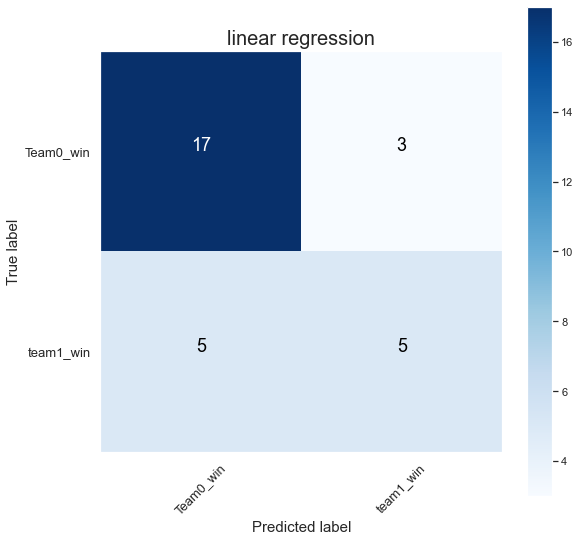

In [49]:
sns.set_theme(style='dark')
class_labels = ('Team0_win', 'team1_win')
ptool.plot_confusion_matrix(classes=class_labels, model="linear regression", pred=predWinner, labels=trueWinner)

# 3) naive bayes, knn, logistic classification, xgboost

Now we shall try some different machine learning methods and compare the performance!

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import math
import sklearn.metrics as skm
from scipy.stats import zscore
import pandas as pd
import numpy as np

again split up the dataset where now the winner (0/1) is the output class

In [51]:
x_train, x_test, y_train, y_test = train_test_split(ncaa_matchup_df[train_cols], ncaa_matchup_df["Winner"], test_size=0.25, random_state=0)

Create the Gaussian Naive Bayes, KNN classifier (various neighbour amounts), Logistic regression, xgb (maxdepth=4) and random forest classifiers

In [52]:
# Gaussian Naive Bayes
gnb = GaussianNB()

# knn-classifier
knn3 = KNeighborsClassifier(n_neighbors=3)
knn4 = KNeighborsClassifier(n_neighbors=4)
knn5 = KNeighborsClassifier(n_neighbors=5)

#logistic regression
lrg = LogisticRegression(solver='lbfgs', multi_class='auto')

#XGBoost
xgb = XGBClassifier()
xgb.max_depth=4

#random forests
rfr = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=0, class_weight="balanced")

fit models to data and output both prediction probabilities and predicted outputs (0 or 1)

In [53]:
#gaussian naive bayes classifier
y_GNB_pred = gnb.fit(x_train, y_train).predict(x_test); y_gnb_prob = gnb.predict_proba(x_test)

#k nearest neighbours
y3_pred = knn3.fit(x_train, y_train).predict(x_test); y_knn_prob = knn3.predict_proba(x_test)
y4_pred = knn4.fit(x_train, y_train).predict(x_test)
y5_pred = knn5.fit(x_train, y_train).predict(x_test)

#logistic regression
y_lrg_pred = lrg.fit(x_train, y_train).predict(x_test); 
y_lrg_prob = lrg.predict_proba(x_test)

#xgboost classifier
y_xgb_pred = xgb.fit(x_train, y_train).predict(x_test); y_xgb_prob = xgb.predict_proba(x_test)

#random forests
y_rfr_pred = rfr.fit(x_train, y_train).predict(x_test); y_rfr_prob = rfr.predict_proba(x_test)

In [54]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

# 4) Evaluation

Compare the ROC curves and ROC_AUC metric for the different models.

The resulting plot tells us the following:
- The Naive Bayes classifier demonstrated the best classification performance. Perhaps the probabilistic approach, using prior information to compute likelihoods, works best in our feature regime
- k nearest neighbours and logistic regression show similar performance in terms of learning weights to predict outcomes
- the decision based methods (XGBoost, random forests) came in last place for this application. Likely a more robust dataset is required to improve performance with these models

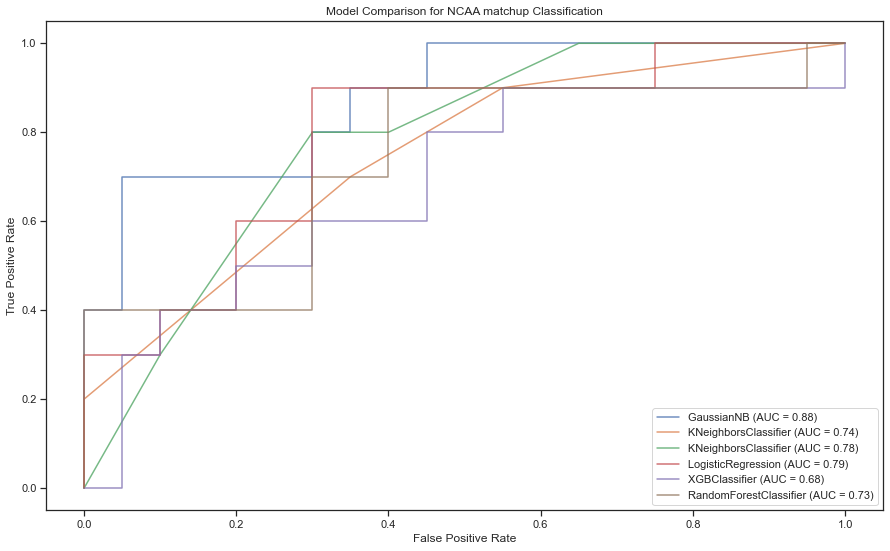

In [76]:
sns.set_style('ticks')
fig = plt.figure(figsize = (15,9))
ax = plt.gca()
gnb_plot = metrics.plot_roc_curve(gnb, x_test, y_test, ax=ax, alpha=0.8)
knn3_plot = metrics.plot_roc_curve(knn3, x_test, y_test, ax=ax, alpha=0.8)
knn5_plot = metrics.plot_roc_curve(knn5, x_test, y_test, ax=ax, alpha=0.8)
lrg_plot = metrics.plot_roc_curve(lrg, x_test, y_test, ax=ax, alpha=0.8)
xgb_plot = metrics.plot_roc_curve(xgb, x_test, y_test, ax=ax, alpha=0.8)
rfr_plot = metrics.plot_roc_curve(rfr, x_test, y_test, ax=ax, alpha=0.8)
plt.title('Model Comparison for NCAA matchup Classification')
plt.savefig('model_comparison.png', bbox_inches='tight', dpi=600 )

it is interesting to compare the probabilities for the various models compared to the true labels

In [55]:
print("true winner: {}".format(trueWinner.T))
print()
print('gnb prob: {}'.format(y_gnb_prob.transpose()))
print('\nknn prob: {}'.format(y_gnb_prob.transpose()))
print('\nlgr prob: {}'.format(y_lrg_prob.transpose()))
print('\nxgb prob: {}'.format(y_xgb_prob.transpose()))
print('\nrfr prob: {}'.format(y_rfr_prob.transpose()))

true winner: [[1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0]]

gnb prob: [[ 0.93  0.62  0.97  0.93  0.99  1.00  1.00  0.20  1.00  0.27  0.98  0.97
   0.83  1.00  0.32  0.58  1.00  0.31  0.60  0.36  0.87  0.88  0.36  0.11
   0.98  0.07  0.56  0.86  0.04  0.97]
 [ 0.07  0.38  0.03  0.07  0.01  0.00  0.00  0.80  0.00  0.73  0.02  0.03
   0.17  0.00  0.68  0.42  0.00  0.69  0.40  0.64  0.13  0.12  0.64  0.89
   0.02  0.93  0.44  0.14  0.96  0.03]]

knn prob: [[ 0.93  0.62  0.97  0.93  0.99  1.00  1.00  0.20  1.00  0.27  0.98  0.97
   0.83  1.00  0.32  0.58  1.00  0.31  0.60  0.36  0.87  0.88  0.36  0.11
   0.98  0.07  0.56  0.86  0.04  0.97]
 [ 0.07  0.38  0.03  0.07  0.01  0.00  0.00  0.80  0.00  0.73  0.02  0.03
   0.17  0.00  0.68  0.42  0.00  0.69  0.40  0.64  0.13  0.12  0.64  0.89
   0.02  0.93  0.44  0.14  0.96  0.03]]

lgr prob: [[ 0.96  0.49  0.94  0.85  0.88  0.98  0.96  0.54  0.98  0.50  0.90  0.80
   0.54  0.96  0.59  0.46  0.99  0.49  0.34  0.55  0.65  0.80  0.6

The following classification report shows the following:
- Naive Bayes has the best performance overall and the best job predicting upsets (team1 wins) by far
- the decision based classifiers (XGBoost, random forests) are not doing very well. They could be suffering more largely from the class imbalance and lack of data abundance
- k=3 and k=5 seem to do much better than k=4 for the KNN classifier. This is likely random from smallness of the data set
- logistic regression is great for predicting 0s but not so well at upsets
- simple linear regression -> classification performance is comparable to methods seen here!

In [56]:
#naive bayes
print("-"*50 + "\nGaussian Naive Bayes: ")
print(classification_report(trueWinner, y_GNB_pred))

#knn
print("\n" + "-"*50 + "\nK Nearest Neighbours: ")
print("k=3: "); print(classification_report(trueWinner, y3_pred))
print("\nk=4: "); print(classification_report(trueWinner, y4_pred))
print("\nk=5: "); print(classification_report(trueWinner, y5_pred))

#logistic regression
print("\n" + "-"*50 + "\nLogistic Regression: ")
print(classification_report(trueWinner, y_lrg_pred))

#xgboost
print("\n" + "-"*50 + "\nXGBoost: ")
print(classification_report(trueWinner, y_xgb_pred))

#random forests
print("\n" + "-"*50 + "\nRandom Forests: ")
print(classification_report(trueWinner, y_rfr_pred))

--------------------------------------------------
Gaussian Naive Bayes: 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.78      0.70      0.74        10

    accuracy                           0.83        30
   macro avg       0.82      0.80      0.81        30
weighted avg       0.83      0.83      0.83        30


--------------------------------------------------
K Nearest Neighbours: 
k=3: 
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.50      0.70      0.58        10

    accuracy                           0.67        30
   macro avg       0.66      0.68      0.65        30
weighted avg       0.71      0.67      0.68        30


k=4: 
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.50      0.30      0.37        10

    accuracy        

__confusion matrices__

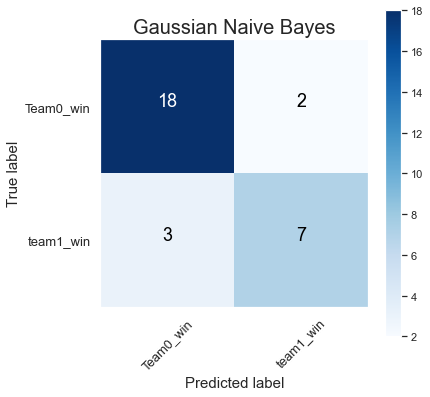

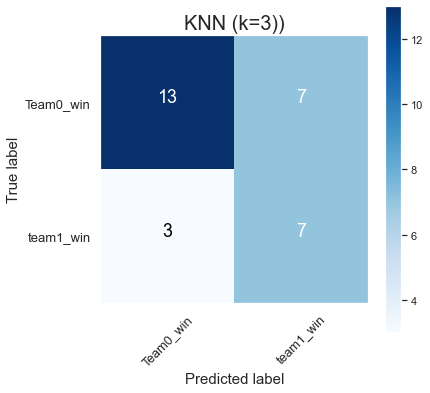

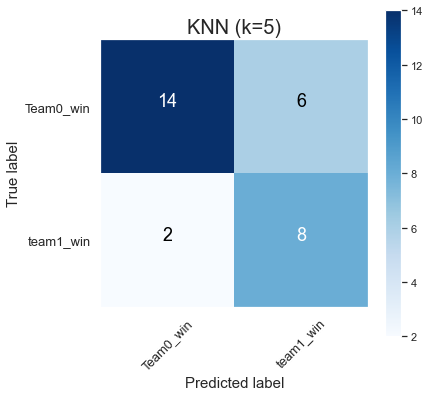

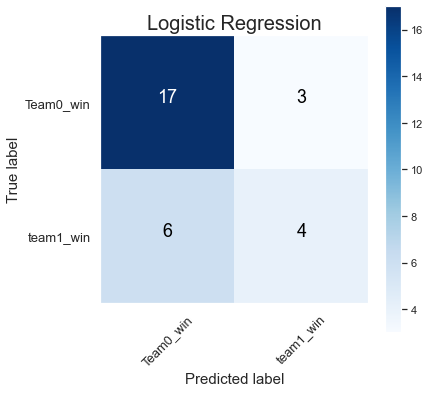

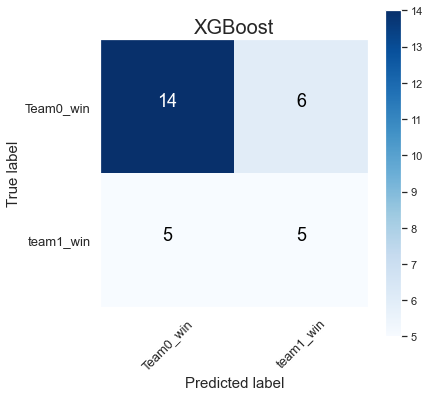

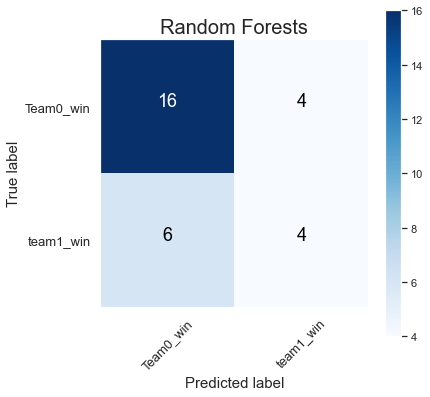

In [57]:
sns.set_theme(style='dark')
class_labels = ('Team0_win', 'team1_win')
ptool.plot_confusion_matrix(classes=class_labels, model="Gaussian Naive Bayes", pred=y_GNB_pred, labels=trueWinner, figsize=(6,6))
ptool.plot_confusion_matrix(classes=class_labels, model="KNN (k=3))", pred=y3_pred, labels=trueWinner, figsize=(6,6))
ptool.plot_confusion_matrix(classes=class_labels, model="KNN (k=5)", pred=y5_pred, labels=trueWinner, figsize=(6,6))
ptool.plot_confusion_matrix(classes=class_labels, model="Logistic Regression", pred=y_lrg_pred, labels=trueWinner, figsize=(6,6))
ptool.plot_confusion_matrix(classes=class_labels, model="XGBoost", pred=y_xgb_pred, labels=trueWinner, figsize=(6,6))
ptool.plot_confusion_matrix(classes=class_labels, model="Random Forests", pred=y_rfr_pred, labels=trueWinner, figsize=(6,6))

# 5) Concluding Thoughts

Data Preparation
- compared to previous related work, configuring the matchups based on statistical differentials led to significantly improved performance (~10-15% higher accuracy)
- Since this dataset is small, we can assume it is unable to generalize very well yet to unseen data. Therefore, it is important to continue to supplement this dataset. Web scraping could be helpful, and transfer learning from other basketball leagues can be applied in future to supplement the size of the training set 

Model Performance
- Linear regression, logistic regression, KNN, XGBoost, random forests, and Gaussian Naive Bayes were all applied to this dataset. The best performance resulted from Naive Bayes (~83% accuracy, 0.88 ROC AUC), and importantly, a f1 score of 0.74 for class 1 which is the imbalanced class and generally more difficult to predict. It appears a probabilitistic approach is well suited to classification of this dataset.
- Logistic regression, logistic classification and KNN methods resulted in middling performance around 67-73%, and reduced predictive ability for the imbalanced class, class 1 (f1 scores from 0.47 to 0.67). The assignment of consistent weights for features might be non-optimizable for baskbetball matchups due to the unpredictable nature of the game. The importance of specific features will vary from matchup to matchup, so it is hard to rely on any specific distribution of weights.
- The decision tree methods (XGBoost, random forests) ranked lowest for performance on this dataset, perhaps due to the lack of lots of training examples, causing the models to have trouble generating consistent decision methods. Accuracy was 63-67% and team1 f1 score was 0.44-0.48. These methods are expected to improve with the inclusion of more data.